# Single cell impedance analysis

Copyright (c) 2025 Open Brain Institute

Authors: Aurélien Jaquier

last modified: 01.2025

## Description

This notebook runs a single cell with a ZAP stimulus, records its current input and voltage output, uses them to compute the cell's impedance and plots the impendance vs frequency graph.

In order to run this notebook, you will need to download an emodel from the Open Brain Institute Platform and have it under a folder named emodel.

You will also have to have Neuron, BlueCelluLab, BluePyEModel and matplotlib installed.

You will have first to compile the mechanisms. This notebook expects the hoc emodel, the morphology and the mechanisms to be in a folder named emodel. Run the following cell to compile the mechanisms:

In [1]:
!nrnivmodl emodel/mechanisms

/Users/aurelien/venvs/venv-py312/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/aurelien/repos/obi_platform_analysis_notebooks/Cellular/single_cell_impedance_analysis
Mod files: "emodel/mechanisms/emodel/mechanisms/CaDynamics_DC0.mod" "emodel/mechanisms/emodel/mechanisms/Ca_HVA2.mod" "emodel/mechanisms/emodel/mechanisms/Ca_LVAst.mod" "emodel/mechanisms/emodel/mechanisms/Ih.mod" "emodel/mechanisms/emodel/mechanisms/K_Pst.mod" "emodel/mechanisms/emodel/mechanisms/K_Tst.mod" "emodel/mechanisms/emodel/mechanisms/NaTg.mod" "emodel/mechanisms/emodel/mechanisms/Nap_Et2.mod" "emodel/mechanisms/emodel/mechanisms/SK_E2.mod" "emodel/mechanisms/emodel/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


First, we'll have to load every module that are needed in this notebook:

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from bluecellulab import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation import Simulation
from bluecellulab.stimulus import StimulusFactory
from bluecellulab.tools import calculate_rheobase
from bluepyemodel.emodel_pipeline.plotting_utils import get_impedance


--No graphics will be displayed.


We'll know open the metadata.json file in order to get all the files names, and be able to load them:

In [3]:
emodel_folder = Path("emodel")
with open(emodel_folder / "metadata.json") as f:
    metadata = json.load(f)
hoc_file = emodel_folder / metadata["hoc_file"]
morph_file = emodel_folder / metadata["morph_file"]
mechanisms_folder = emodel_folder / metadata["mechanisms_folder"]
threshold_current = metadata["threshold_current"]
holding_current = metadata["holding_current"]
emodel_name = metadata["emodel_name"]

Now, we will get the holding current and the threshold current from the metadata. If they are not available, we will use default values of 0 for both for now, and compute the threshold current later on.

In [4]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
compute_threshold = False
if threshold_current is None:
    compute_threshold = True
    threshold_current = 0
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

Now that we have the holding and threshold current (or placeholder values if they were not in the metadata), we can create our cell using BlueCelluLab:

In [5]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Now that we have a cell, we can compute its threshold current if it was not provided in the metadata. First, we compute its RMP (resting membrane potential) and Rin (internal resistance) to get a maximum bound for threshold current, and use a bisection search algorithm. BlueCelluLab can handle all of that:

In [6]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

And we can print the holding and threshold currents:

In [7]:
print(f"holding current is {emodel_properties.holding_current} nA.")
print(f"threshold current is {emodel_properties.threshold_current} nA.")

holding current is -0.0640625 nA.
threshold current is 0.08304913631110189 nA.


We will now create a sinespec protocol with a ZAP stimulus. We will provide a small delay of 300 ms in order to let the cell settle to its resting state before stimulating it. We can also set the time step. Here, we will set to 0.1 ms. Once again, BlueCelluLab takes care of creating the stimulus for us:

In [8]:
stim_factory = StimulusFactory(dt=0.1)
sinespec = stim_factory.sinespec(threshold_current=emodel_properties.threshold_current, pre_delay=300)

Now, we can inject the stimulus into the cell, run it, and get its recorded time, current input, and voltage output. The voltage recording is already defined in BlueCelluLab, but not the injected current, so we have to add it as a recording by hand. Note that this can take a few seconds to run.

In [9]:
cell.inject_current_waveform(t_content=sinespec.time, i_content=sinespec.current)
current_rec = "neuron.h.IClamp[0]._ref_i"
cell.add_recording(current_rec)
sim = Simulation(cell)
print("Running the simulation...")
sim.run(sinespec.stimulus_time, dt=0.1)
print("Done.")
time, voltage, current = cell.get_time(), cell.get_soma_voltage(), cell.get_recording(current_rec)

Running the simulation...
Done.


Now, we can compute the impedance at all frequencies up to 50 Hz, and extract the frequency at which the impedance is maximal, using the BluePyEModel get_impedance function:

In [10]:
freq, smooth_Z = get_impedance(
    time,
    voltage,
    current,
    300.0,
    5300.0,
    efel_settings={},
)
if freq is None or smooth_Z is None:
    raise TypeError("Could not compute the impedance.")
imp_arg = np.argmax(smooth_Z)
imp_freq = freq[imp_arg]
print(f"Impedance is maximal at {imp_freq} Hz.")

Impedance is maximal at 7.772806060715979 Hz.


Finally, we can plot our input current trace, output voltage trace, and impedance vs frequency plot, and save it as a pdf in the figures folder:

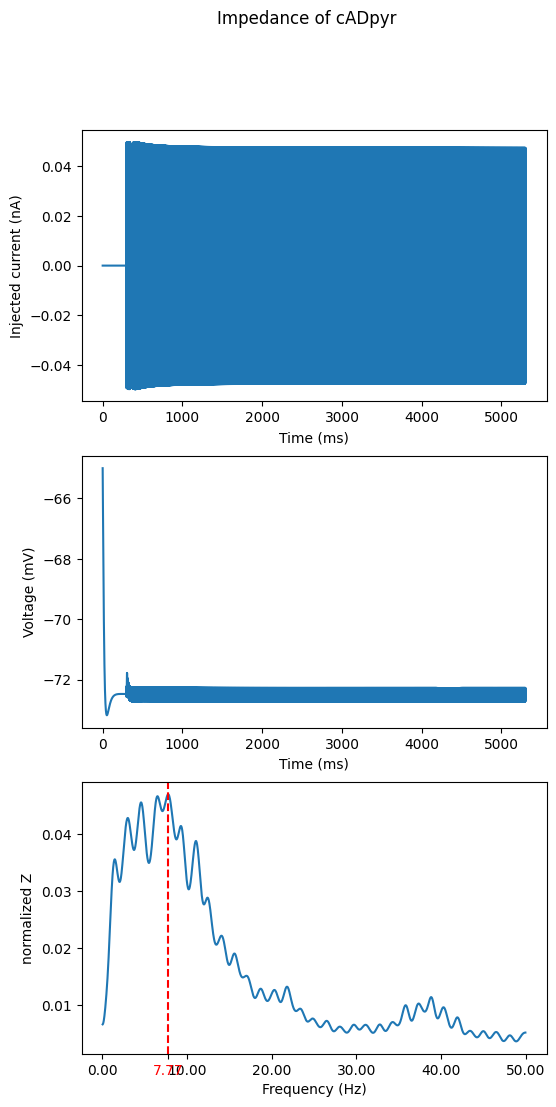

In [11]:
fig, axs = plt.subplots(3, figsize=(6, 12))
axs[0].plot(time, current)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Injected current (nA)")

# voltage trace
axs[1].plot(time, voltage)
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Voltage (mV)")

# impedance trace
axs[2].plot(freq, smooth_Z)
axs[2].axvline(imp_freq, ls="--", c="red")
xlim = axs[2].get_xlim()
new_xticks = list(axs[2].get_xticks()) + [imp_freq]
axs[2].set_xticks(new_xticks)
axs[2].xaxis.get_ticklabels()[-1].set_color("red")
# we have to re-set xlim after adding an xtick
axs[2].set_xlim(xlim)
axs[2].set_xlabel("Frequency (Hz)")
axs[2].set_ylabel("normalized Z")

fig.suptitle(f"Impedance of {emodel_name}")

output_path = Path("figures")
output_path.mkdir(exist_ok=True)
plt.savefig(output_path / "impedance_analysis.pdf")
plt.show()